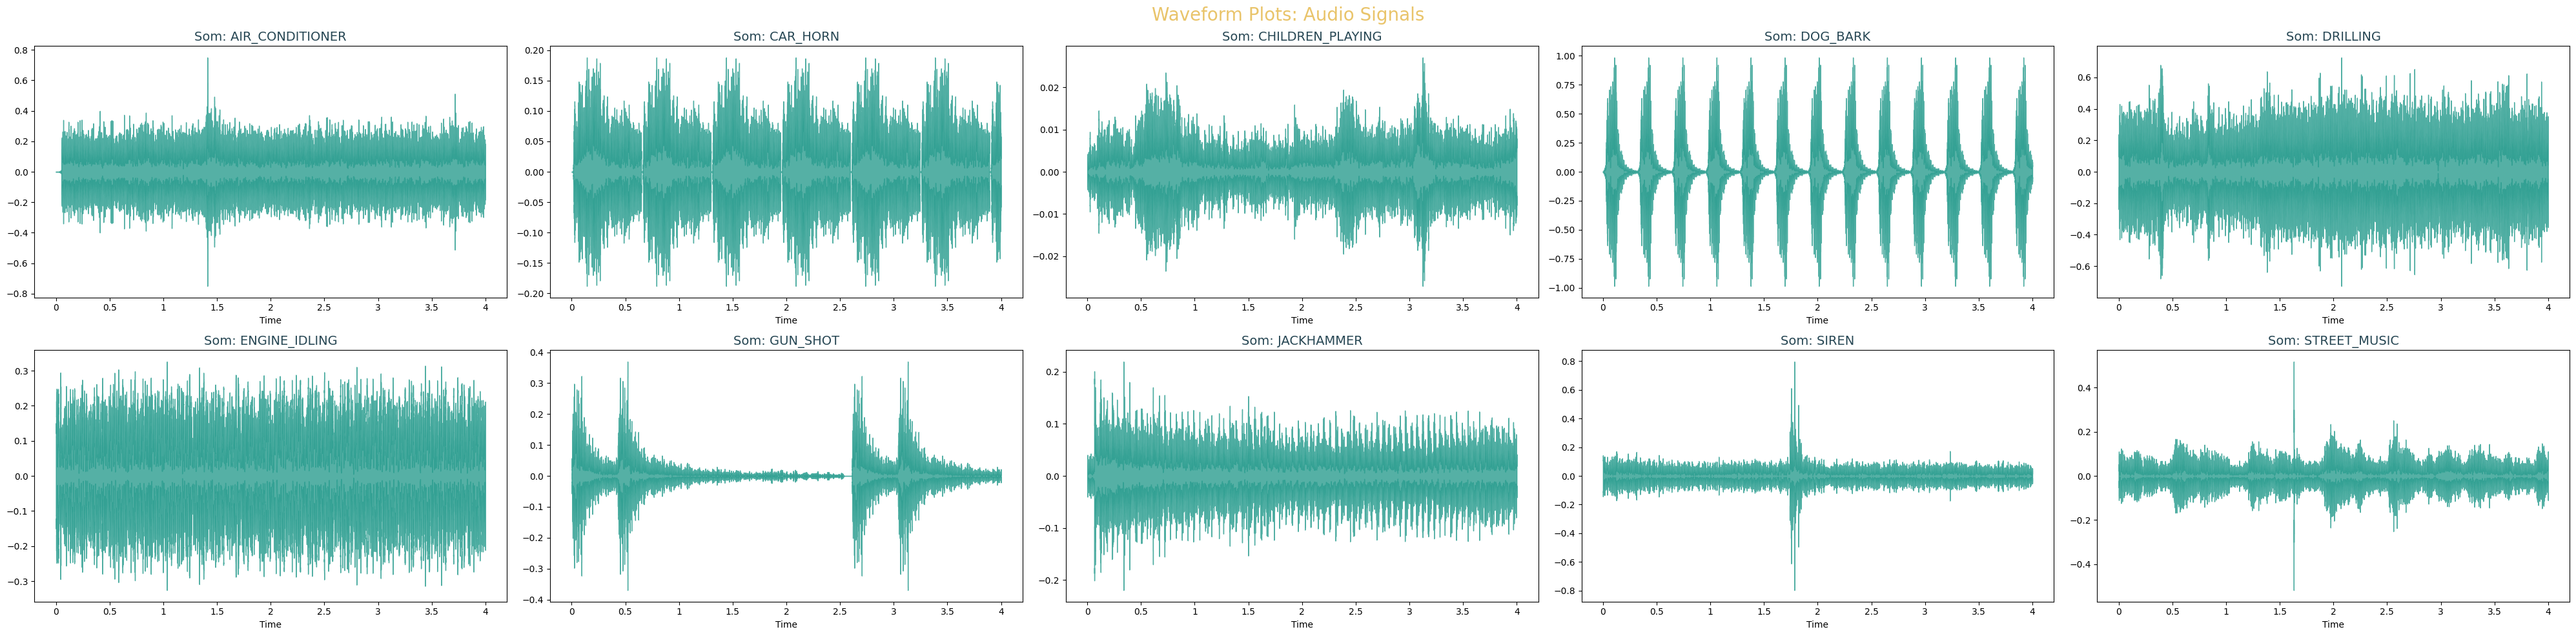

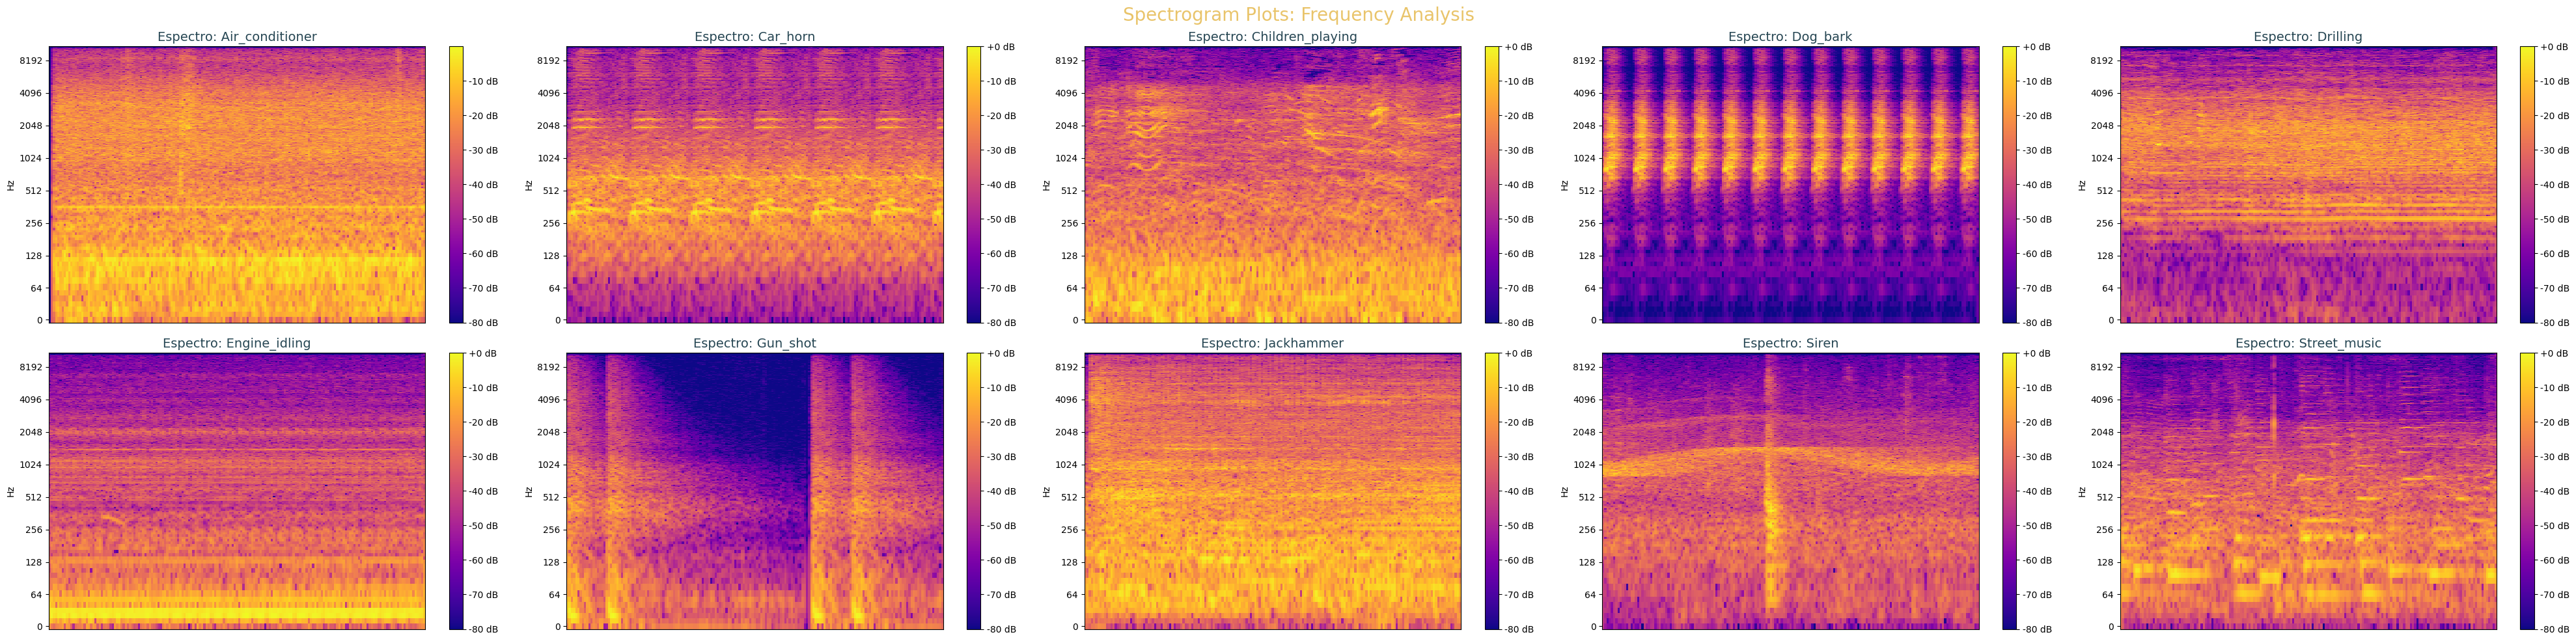

In [3]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Função para carregar os arquivos de áudio
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load(fp, sr=None)  # sr=None para manter a taxa de amostragem original
        raw_sounds.append(X)
    return raw_sounds

# Função para plotar a forma de onda dos áudios
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10))  # Tamanho da figura maior para melhorar a visualização

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        librosa.display.waveshow(np.array(f), sr=22050, color='#2a9d8f', alpha=0.8, where='post')  # Cor verde-azulada
        plt.title(f"Som: {n.upper()}", fontsize=14, color='#264653')  # Títulos com um tom mais escuro
        i += 1

    fig.suptitle('Waveform Plots: Audio Signals', fontsize=20, color='#e9c46a')  # Título principal em amarelo
    plt.tight_layout()
    plt.show()

# Função para plotar o espectrograma dos áudios
def plot_spec(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(40, 10))  # Tamanho da figura ajustado

    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2, 5, i)
        d = librosa.amplitude_to_db(np.abs(librosa.stft(f)), ref=np.max)
        librosa.display.specshow(d, y_axis='log', cmap='plasma')  # Espectrograma com mapa de cores 'plasma'
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Espectro: {n.capitalize()}", fontsize=14, color='#264653')  # Título com cor mais escura
        i += 1

    fig.suptitle('Spectrogram Plots: Frequency Analysis', fontsize=20, color='#e9c46a')  # Título principal
    plt.tight_layout()
    plt.show()

# Defina o caminho do arquivo CSV e obtenha a lista de classes
path_csv = 'UrbanSound8K/metadata/UrbanSound8K.csv'
df = pd.read_csv(path_csv)

# Obtenha a lista de classes a partir da coluna 'class' no CSV
classes = list(np.unique(df['class']))

# Gere a lista de caminhos dos arquivos de áudio para visualização
sound_file_paths = [
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100852-0-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10', '100648-1-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100263-2-0-117.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold5', '100032-3-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold3', '103199-4-0-3.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold10', '102857-5-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold1', '102305-6-0-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold1', '103074-7-1-0.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7', '102853-8-0-2.wav'),
    os.path.join('UrbanSound8K', 'audio', 'fold7', '101848-9-0-9.wav')
]

# Carregar os áudios
raw_sounds = load_sound_files(sound_file_paths)

# Plotar as formas de onda e espectrogramas
plot_waves(classes, raw_sounds)
plot_spec(classes, raw_sounds)


In [ ]:
import tensorflow as tf
import itertools
from sklearn.model_selection import train_test_split

# Classe MLP
class MLP(tf.keras.Model):
    def __init__(self, input_dim, output_dim, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        self.hidden_layers = []
        for units in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(units, activation='relu'))
            self.hidden_layers.append(tf.keras.layers.Dropout(dropout_rate))
        self.output_layer = tf.keras.layers.Dense(output_dim, activation='softmax')  # Para classificação multi-classe

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)


In [ ]:
configurations = {
    "hidden_units": [[128, 64], [256, 128, 64], [64, 32]],  # Número de neurônios por camada
    "dropout_rate": [0.3, 0.5],                             # Taxas de dropout
    "batch_size": [32],                                     # Tamanho de batch fixado em 32
    "epochs": [20],                                         # Fixado em 20 épocas
    "learning_rate": [0.001, 0.0001]                        # Taxas de aprenudizado
}


In [ ]:
def train_evaluate_model(config, X_train, y_train, X_val, y_val):
    model = MLP(input_dim=X_train.shape[1],
                output_dim=10,
                hidden_units=config['hidden_units'],
                dropout_rate=config['dropout_rate'])
    
    # Compilar o modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Configurar Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  # Parar após 5 épocas sem melhora
        restore_best_weights=True  # Restaurar os melhores pesos ao final
    )
    
    # Treinar o modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=[early_stopping],  # Adicionar o callback
        verbose=1
    )
    
    # Retornar a melhor acurácia na validação
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy


In [ ]:
def generate_configs(configurations):
    keys, values = zip(*configurations.items())
    return [dict(zip(keys, v)) for v in itertools.product(*values)]

# Preparar os dados
def prepare_data(features, labels):
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

# Dados simulados (substituir com suas features e labels reais)
features = ...  # Array de características (exemplo: np.array(features))
labels = ...    # Array de rótulos (exemplo: np.array(labels))

# Dividir os dados
X_train, X_val, y_train, y_val = prepare_data(features, labels)

# Rodar experimentos para encontrar a melhor configuração
best_accuracy = 0
best_config = None

for config in generate_configs(configurations):
    print(f"Testing configuration: {config}")
    accuracy = train_evaluate_model(config, X_train, y_train, X_val, y_val)
    print(f"Accuracy for this configuration: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f"Best configuration: {best_config}, Best accuracy: {best_accuracy}")
